In [4]:
%matplotlib inline

In [17]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import timedelta, datetime
from joblib import delayed, Parallel
from copy import copy

from core import  do_simulation
from helpers import Params, T, get_T1_and_T2, R0, plot_total, DATE_FORMAT, total_to_csv,  save_to_json, save_bundle, makedir_if_not_there

from const import STATE, COLORS, NUM_STATES,  STATES


In [6]:
p0_time = pkl.load(open('output/p0_time.pkl', 'rb'))
lockdown_time = T('23/01/2020')
days_before_ld  = (lockdown_time -  p0_time).days
params_before = pkl.load(
    open('output/params_before_lockdown.pkl', 'rb')
)

params_after = pkl.load(
    open('output/params_after_lockdown.pkl', 'rb')
)

bed_info = pkl.load(open('data/bed_info.pkl', 'rb'))

infection_factor = 1.999881671966743

In [7]:
bed_info

[(0, 3000),
 (58, 1000),
 (64, 6000),
 (68, 1000),
 (71, 2000),
 (75, 6000),
 (81, 11000),
 (85, 11000)]

In [11]:
total_days = 360

def one_run(event_factor, event_date):
    days_before_event = (event_date - p0_time).days
    days_before_event
    alpha_list = [
        (0, params_before.alpha),
        (days_before_event, event_factor * params_before.alpha),
        (days_before_ld, params_after.alpha)
    ]
    beta_list = [
        (0, params_before.beta),
        (days_before_event, params_before.beta),
        (days_before_ld, params_after.beta)
    ]

    p = Params(
        alpha=alpha_list,
        beta=beta_list,
        stages=[days_before_event, days_before_ld],
        initial_num_E=1,
        initial_num_I=0,
        initial_num_M=0,
        mu_ei=params_after.mu_ei,
        mu_mo=params_after.mu_mo,
        k_days=params_after.k_days,
        x0_pt=params_after.x0_pt,        
    )

    total, delta, increase, trans, stats = do_simulation(total_days, bed_info, p, p0_time=p0_time)
    bundle = [total, delta, increase, trans]
    return event_factor, event_date, bundle, stats

In [19]:
event_dates = [
    T('16/01/2020'), T('17/01/2020'), T('18/01/2020'),
    T('19/01/2020'), T('20/01/2020'), T('21/01/2020'), T('22/01/2020')
]

factors = np.arange(1, 1.251, step=0.05)
#  factors = np.arange(1, 9, step=1)
rows = Parallel(n_jobs=-1)(
    delayed(one_run)(factor, event_date)
    for factor, event_date in product(factors, event_dates)
)

factor = 1.0
event_date= 2020-01-16 00:00:00
['28/11/19' '08/02/20' '20/04/20' '01/07/20' '11/09/20' '22/11/20']


/home/cloud-user/code/covid-19/helpers.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['index'] = df.index
/home/cloud-user/code/covid-19/helpers.py:286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['value'] = subdf[state].copy()
/home/cloud-user/code/covid-19/helpers.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

factor = 1.05
event_date= 2020-01-17 00:00:00
['28/11/19' '08/02/20' '20/04/20' '01/07/20' '11/09/20' '22/11/20']
factor = 1.1
event_date= 2020-01-18 00:00:00
['28/11/19' '08/02/20' '20/04/20' '01/07/20' '11/09/20' '22/11/20']
factor = 1.1500000000000001
event_date= 2020-01-19 00:00:00
['28/11/19' '08/02/20' '20/04/20' '01/07/20' '11/09/20' '22/11/20']
factor = 1.2000000000000002
event_date= 2020-01-20 00:00:00
['28/11/19' '08/02/20' '20/04/20' '01/07/20' '11/09/20' '22/11/20']
factor = 1.2500000000000002
event_date= 2020-01-21 00:00:00
['28/11/19' '08/02/20' '20/04/20' '01/07/20' '11/09/20' '22/11/20']


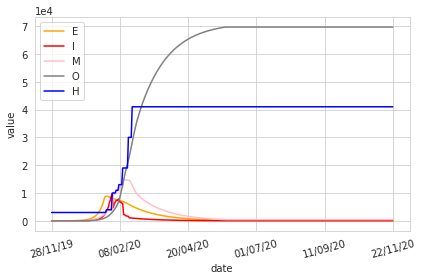

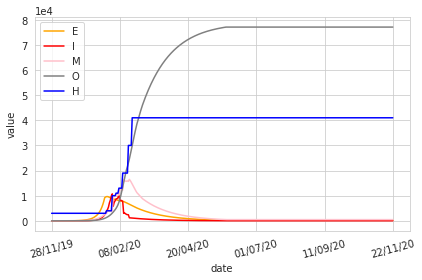

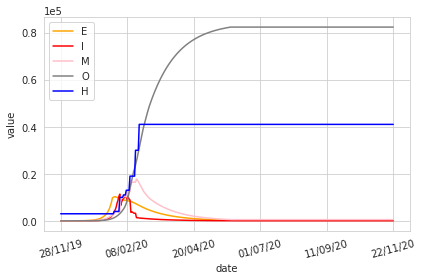

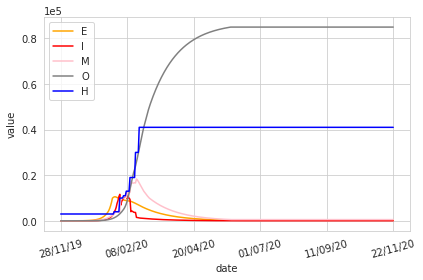

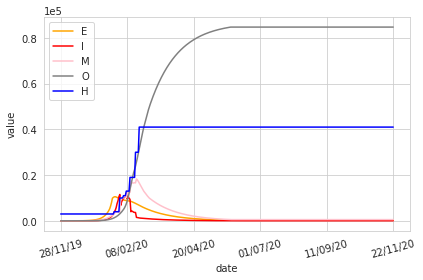

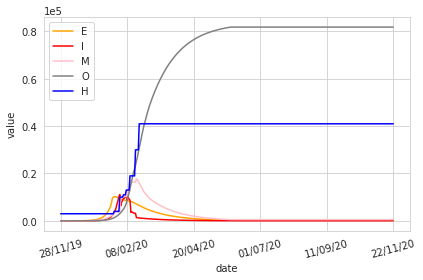

In [18]:
for event_factor, event_date, bundle, stats in rows:    
    print('factor =', event_factor)
    print('event_date=', event_date)
    fig, ax = plot_total(bundle[0], p0_time, total_days)
    
    date_str = event_date.strftime('%Y-%m-%d')
    
    fig_dir = f'figs/public-event/{date_str}'
    data_dir = f'output/tbl/public-event/{date_str}/{event_factor}'
    makedir_if_not_there(fig_dir)
    makedir_if_not_there(data_dir)
    
    fig.savefig(f'{fig_dir}/{event_factor}.pdf')
    event_factor = '{:.2f}'.format(event_factor)
    save_bundle(bundle, p0_time, total_days, f'{data_dir}')
    save_to_json(stats, f'{data_dir}/stats.txt')    

In [22]:
# df = pd.DataFrame(r0_rows, columns=['factor', 'before  event', 'after event', 'after lockdown'])
# df
# df.to_csv('output/tbl/public-event/r0.csv', index=None)